### Import stuff

In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from scipy import optimize
import time
from tqdm import tqdm
from saxs import ScatterData
from methods import *
from plot_utils import *
from scipy.signal import savgol_filter

# Load data

## Load diff data from EuXFEL

In [2]:
# Path where XFEL data is 
XFEL_path = '/home/leonardo/SAXS_222711/data_csv/Hamburg_data'

# Get the time points of the the data, as well as time resolved data
time_points = np.array([float(file.replace('us_averaged.npy','')) for file in os.listdir(XFEL_path) if 'us' in file])
XFEL_tr = np.array([os.path.join(XFEL_path,file) for file in os.listdir(XFEL_path) if 'us' in file])

# Sort from slowest timpoints to the fastest timepoints. 
sort_ind = np.argsort(time_points)[::-1]
time_points = time_points[sort_ind]
XFEL_tr = XFEL_tr[sort_ind]

# Keep ScatterData in list for easy access 
XFEL_empty = [ScatterData() for i in range(XFEL_tr.shape[0])]
# Load q vector from XFEL 
XFEL_q = np.load(f'/home/leonardo/SAXS_222711/data_csv/Hamburg_data/q.npy')

# Iterate over time resolved data and set I and q for ScatterData
XFEL_data = []
for data,i in zip(XFEL_empty, XFEL_tr):
    intensity = np.load(i)
    data.set_data(XFEL_q,intensity)
    XFEL_data.append(data)
print(time_points)

[269.51 223.41 180.85 136.53  92.2   47.88   3.55]


## Load SAXS data - Measurement 1, FEB 2023

In [3]:
#Load data from Diamond 20C 15mg/ml
dark_path = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_measurement1_Dark_sub/csv'
light_path = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_measurement1_Light_sub/csv'

# Get the data from files and creates ScatterData object that are stored in lists
dark_files = np.array([os.path.join(dark_path,file) for file in os.listdir(dark_path)])
light_files = np.array([os.path.join(light_path,file) for file in os.listdir(light_path)])
time_steady = [10,10,20,20]

SAXS_dark_steady = []
SAXS_light_steady = []
SAXS_diff_steady = []
                       
for light, dark in zip(light_files,dark_files):
    dark = ScatterData(dark)
    light = ScatterData(light)
    diff_SAXS = calc_diff(light,dark)
    SAXS_dark_steady.append(dark)
    SAXS_light_steady.append(light)
    SAXS_diff_steady.append(diff_SAXS)
    


## Load SAXS data - Measurement 2, FEB 2023

In [212]:
dark_path = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Dark/csv'
light_path = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Light/csv'
buffer_dark = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_buffer/csv/dark_buffer'
buffer_light = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_buffer/csv/light_buffer'


dark_files = [os.path.join(dark_path,file) for file in os.listdir(dark_path)]
light_files = [os.path.join(light_path,file) for file in os.listdir(light_path)]
dark_buffer = [os.path.join(buffer_dark,file) for file in os.listdir(buffer_dark)]
light_buffer = [os.path.join(buffer_light,file) for file in os.listdir(buffer_light)]

dark_files.sort()
light_files.sort()
dark_buffer.sort()
light_buffer.sort()

print(dark_files)
print(light_files)
print(dark_buffer)
print(light_buffer)

time_illumination = [1,2,5,10]
SAXS_dark_illumination = []
SAXS_light_illumination = []
SAXS_diff_illumination = []
                       
for light, dark, light_buffer, dark_buffer in zip(light_files, dark_files, light_buffer, dark_buffer):
    dark = ScatterData(dark)
    light = ScatterData(light)

    
    diff_SAXS = calc_diff(light,dark)
    SAXS_dark_illumination.append(dark)
    SAXS_light_illumination.append(light)
    SAXS_diff_illumination.append(diff_SAXS)
    


['/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Dark/csv/00114_AsLOV2_measurment2.dat.csv', '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Dark/csv/00118_AsLOV2_measurment2.dat.csv', '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Dark/csv/00122_AsLOV2_measurment2.dat.csv', '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Dark/csv/00126_AsLOV2_measurment2.dat.csv', '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Dark/csv/00130_AsLOV2_measurment2.dat.csv']
['/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Light/csv/00116_AsLOV2_measurment2.dat.csv', '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Light/csv/00120_AsLOV2_measurment2.dat.csv', '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Light/csv/00124_AsLOV2_measurment2.dat.csv', '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Light/csv/00128_AsLOV2_measurment2.dat.csv']
['/home/leonardo/SAXS_DATA_FEB23/AsLOV2_buffer/csv/dark_buffer/00078_buffer_AsLOV2.dat.csv', '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_buffer/csv/dark_buffer/00082_buffer_AsLOV2.

## Load SAXS - Temperature experiment Nov 22

In [5]:
temp_saxs_path = '/home/leonardo/SAXS_222711/data_csv/temperature_exp'
temperatures = np.array([int(file.replace('AsLOV2_15mgml_','').replace('C_average_average.dat.csv','')) for file in os.listdir(temp_saxs_path)])
temp_saxs = np.array([os.path.join(temp_saxs_path,file) for file in os.listdir(temp_saxs_path)])

# Sort temperature from highest to lowest as well as the data files
sort_ind = np.argsort(temperatures)[::-1]
temperatures = temperatures[sort_ind]
temp_saxs = temp_saxs[sort_ind]
SAXS_temp = [ScatterData(file) for file in temp_saxs]

## Load absolute data from XFEL

In [166]:
#Load Dark and Light data from XFEL
dark_path = '/home/leonardo/SAXS_222711/data_csv/Hamburg_data/Dark'
light_path = '/home/leonardo/SAXS_222711/data_csv/Hamburg_data/Light'

dark_files = np.array([os.path.join(dark_path,file) for file in os.listdir(dark_path)])
light_files = np.array([os.path.join(light_path,file) for file in os.listdir(light_path)])

buffer_dark = np.load('/home/leonardo/SAXS_222711/data_csv/Hamburg_data/Buffer_off_runr0133.npy')
buffer_light =np.load('/home/leonardo/SAXS_222711/data_csv/Hamburg_data/Buffer_on_runr0133.npy')

buffer_light = np.nansum(buffer_light[150:175,:],axis = 0)/25
buffer_dark =np.nansum(buffer_dark[150:175,:],axis = 0)/25

darks = np.zeros((5,176,XFEL_q.shape[0]))
lights = np.zeros((5,176,XFEL_q.shape[0]))

for i,states in enumerate(zip(dark_files, light_files)):
    dark,light = states
    d = np.load(dark)
    l = np.load(light)
    darks[i] = d[:176]
    lights[i] = l[:176]

dark = (np.sum(darks,axis=0))/len(dark_files)
dark = np.sum(dark[150:175,:],axis = 0)/25

light = (np.sum(lights,axis=0))/len(light_files)
light = np.sum(light[150:175,:],axis = 0)/25

# Factor of 0.935 for buffer subtraction matching the SAXS baseline 
XFEL_dark = buffer_sub(dark, buffer_dark,XFEL_q,.935)
XFEL_dark_theo = buffer_sub(dark, buffer_dark,XFEL_q,.905)
XFEL_light= buffer_sub(light, buffer_light,XFEL_q,.935)

XFEL_light = XFEL_light.remove_nan()
XFEL_dark_theo = XFEL_dark_theo.remove_nan()
XFEL_dark = XFEL_dark.remove_nan()


## Plot data for verification

### Plot buffer subtracted data

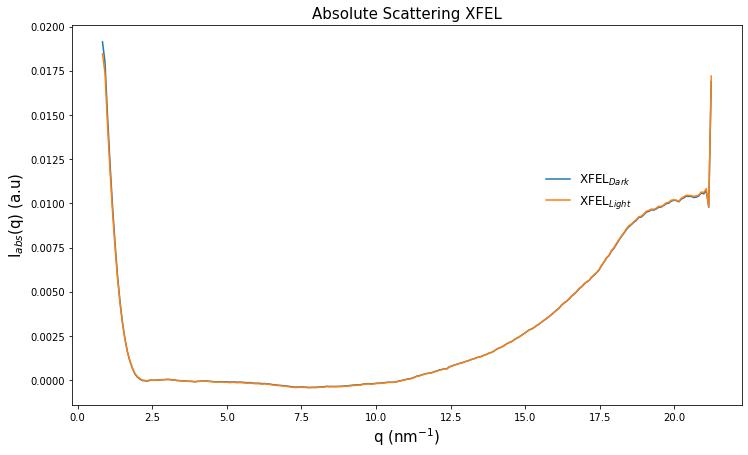

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(XFEL_dark.q,XFEL_dark.i, label=r'XFEL$_{Dark}$')
ax.plot(XFEL_light.q,XFEL_light.i, label=r'XFEL$_{Light}$')
ax.legend(loc=(0.7, 0.5), frameon=False, fontsize=12)
ax.set_title('Absolute Scattering XFEL', fontsize=15)
ax.set_ylabel(r'I$_{abs}$(q) (a.u)', fontsize=15)
ax.set_xlabel(r'q (nm$^{-1}$)', fontsize=15)
plt.show()




### Plot Diff data XFEL

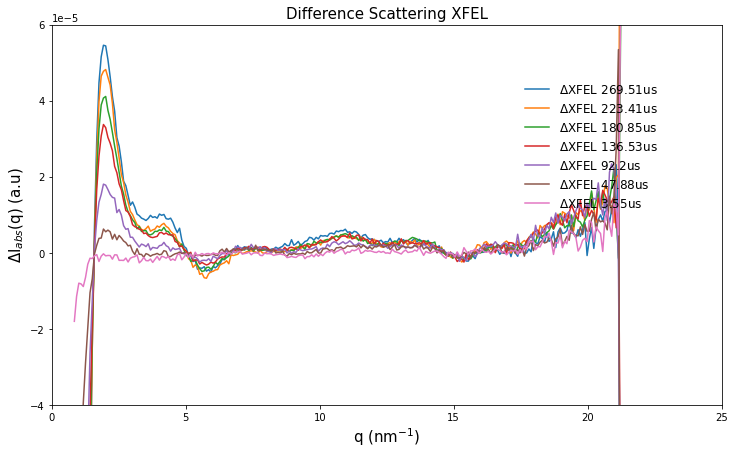

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
for data , time in zip(XFEL_data, time_points):
    ax.plot(data.q,data.i, label=r'$\Delta$XFEL '+str(time)+'us')
ax.legend(loc=(0.7, 0.5), frameon=False, fontsize=12)
ax.set_title('Difference Scattering XFEL', fontsize=15)
ax.set_ylabel(r'$\Delta$I$_{abs}$(q) (a.u)', fontsize=15)
ax.set_xlabel(r'q (nm$^{-1}$)', fontsize=15)
ax.set_ylim([-4e-5,6e-5])
ax.set_xlim([data.q[0],25])
plt.show()


# Temperature differences

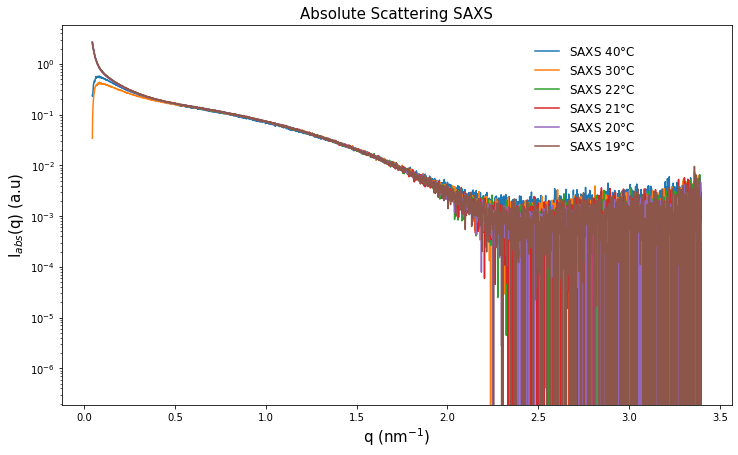

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
for data , temp in zip(SAXS_temp, temperatures):
    ax.plot(data.q*10,data.i, label=r'SAXS '+str(temp)+r'$\degree$C')
ax.legend(loc=(0.7, 0.65), frameon=False, fontsize=12)
ax.set_title('Absolute Scattering SAXS', fontsize=15)
ax.set_ylabel(r'I$_{abs}$(q) (a.u)', fontsize=15)
ax.set_xlabel(r'q (nm$^{-1}$)', fontsize=15)
ax.set_yscale('log')

plt.show()

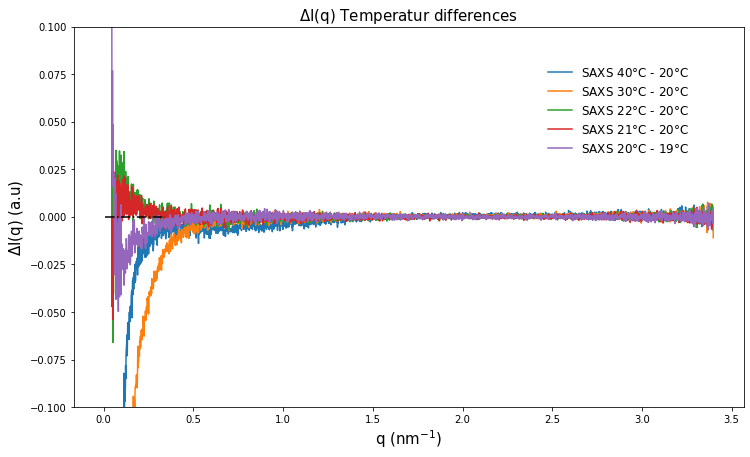

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
for data , temp in zip(SAXS_temp, temperatures):
    if data == SAXS_temp[4]:
        continue
    if data == SAXS_temp[-1]:
        ax.plot(data.q*10,SAXS_temp[4].i-data.i, label=r'SAXS '+str(temperatures[4])+r'$\degree$C - '+str(temp)+r'$\degree$C')
    else:
        ax.plot(data.q*10,data.i-SAXS_temp[4].i, label=r'SAXS '+str(temp)+r'$\degree$C - '+str(temperatures[4])+r'$\degree$C')
ax.legend(loc=(0.7, 0.65), frameon=False, fontsize=12)
ax.set_title('$\Delta$I(q) Temperatur differences', fontsize=15)
ax.set_ylabel(r'$\Delta$I(q) (a.u)', fontsize=15)
ax.set_xlabel(r'q (nm$^{-1}$)', fontsize=15)
ax.hlines(0, xmin = data.q[0], xmax = 0.34, color='k', linestyle='-.')
ax.set_ylim([-.1,.1])

plt.show()

# AlphaFold2 Models


## AF2 load data

In [11]:
AF2_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities/fixed'
names = [file for file in os.listdir(AF2_path)]
names.sort()
files = np.array([os.path.join(AF2_path,file) for file in os.listdir(AF2_path)])
ind = np.argsort(files)
AF2_data = np.array([ScatterData(file) for file in files])
AF2_data = AF2_data[ind]

/home/leonardo/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


## Main function for calculating various metrics

In [114]:
def calc_metrics(q_min,q_max,k,n): 
    
    save_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book'
    # Adjust exp. difference data to q-range 
    exp_diff_cut = XFEL_data_theo[0].cut_q(q_min,q_max)
    exp_diff_cut = exp_diff_cut.remove_nan()

    exp_dark_cut = XFEL_dark.cut_q(q_min,q_max)
    exp_dark_cut = exp_dark_cut.remove_nan()
    
    theory_ref = AF2_data[0].scale_q(10)
    theory_ref= theory_ref.cut_q(q_min,q_max)
    
    # Interpolate exp. difference data
    exp_diff_interpolated = interpolate(theory_ref.q,exp_diff_cut)
    exp_diff_interpolated_scaled_I = exp_diff_interpolated.scale_intensity(1e5)
    exp_diff_interpolated_scaled_cc = exp_diff_interpolated.scale_intensity(1/exp_diff_interpolated.q)
    
    # Interpolate exp. absolute data
    exp_abs_interpolated = interpolate(theory_ref.q,XFEL_dark)
    exp_abs_interpolated_scaled_I = exp_abs_interpolated.scale_intensity(1e5)
    #Define list with metrics
    corr_final = []
    R2 = []
    fopts = []
    light_index = []
    dark_index = []
    occupancies = []
    diff_scale = []
    abs_scale = []
    
    print(f'Running {2000-n} models')
    # Iterate over each model in the list of models
    for model1 in tqdm(AF2_data[n:]):
        index1 = n 
        n += 1
        index2 = n
        # Iterate over the models after current model to calculate half difference matrix
        for model2 in AF2_data[index2:]:    
            if model1 == model2:
                continue
            # Scale the data with 1/q to maximize the small q region 
            theory_diff = calc_diff(model1, model2)
            theory_diff = theory_diff.scale_q(10)
            theory_diff = theory_diff.cut_q(q_min,q_max)
            theory_scaled_cc = theory_diff.scale_intensity(1/theory_diff.q)
            #print(theory_scaled_cc.i/theory_diff.q)
            
            # Scale exp. diff and exp. abs to theory (factor of 1*e5 for faster calc.)
            scale_diff,fopt_diff = SSE(exp_diff_interpolated_scaled_I.i,theory_diff.i, 0.0002)
            
            # To find which model is dark and light 
            if scale_diff > 0:
                model1_adjusted = model1.scale_q(10)
                model1_adjusted = model1_adjusted.cut_q(q_min,q_max)
                scale_abs,fopt_abs = SSE(exp_abs_interpolated_scaled_I.i, model1_adjusted.i, 0.0002)
                light_index.append(index1)
                dark_index.append(index2)
            else:
                model2_adjusted = model2.scale_q(10)
                model2_adjusted = model2_adjusted.cut_q(q_min,q_max)
                scale_abs,fopt_abs = SSE(exp_abs_interpolated_scaled_I.i, model2_adjusted.i, 0.0002)
                light_index.append(index2)
                dark_index.append(index1)
                
            
            # Calculate the R2 between intepolated experimental curve and the theoretical curve
            r2= calc_r2(exp_diff_interpolated.i/scale_diff, theory_diff.i/1e5)
            # Calc Pearson CC
            corr = np.corrcoef(exp_diff_interpolated_scaled_cc.i,theory_diff.i, rowvar=True)[0][1]            
            # Calc occupance
            occupancy = (scale_diff/scale_abs)[0]
            diff_scale.append(scale_diff)
            corr_final.append(corr)
            abs_scale.append(scale_abs)
            R2.append(r2)
            fopts.append(fopt_diff/scale_diff[0])
            occupancies.append(occupancy)
            index2 += 1
            
    np.save(f'{save_path}/occupancy', occupancies)
    np.save(f'{save_path}/correlations',corr_final)
    np.save(f'{save_path}/R2',R2)
    np.save(f'{save_path}/fopts',fopts)
    np.save(f'{save_path}/light_index',light_index)
    np.save(f'{save_path}/dark_index',dark_index)
    np.save(f'{save_path}/diff_scales',diff_scale)
    np.save(f'{save_path}/abs_scales',abs_scale)
    
    # For testing 
    #fig1, ax = plt.subplots(1, 1, figsize=(12, 7))
    #ax.plot(theory_diff.q, theory_diff.i, linewidth=3.0,label='Theory', marker='o')
    #ax.plot(exp_diff_interpolated_scaled_I.q, exp_diff_interpolated_scaled_I.i/scale_diff, linewidth=2.0,label='XFEL_interpolated')
    #ax.plot(XFEL_data[0].q, XFEL_data[0].i, linewidth=2.0,label='XFEL_raw')
    #ax.plot(exp_diff_interpolated.q, exp_diff_interpolated.i, linewidth=2.0,label='XFEL')    
    #ax.set_title('$\Delta$I(q)',fontsize=15)
    #ax.set_ylabel('Intensity (a.u.)',fontsize=15)
    #ax.set_ylim([-.00001,.000065])
    #ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    #ax.legend(loc=(0.75,0.05), frameon = True,fontsize=10)
    
    
    


## Run Main Func. ~ 1h 


In [28]:
import time
start=time.time()
k=0
n=0
q_max = 20
q_min = np.nanmin(XFEL_data[0].q[10])
calc_metrics(q_min,q_max,k,n)
end_time=time.time()
ex_time=round(end_time-start,3)
print(f'Run time: {ex_time} seconds for {2000-n} models')


Running 2000 models


100%|███████████████████████████████████████| 2000/2000 [53:23<00:00,  1.60s/it]


Run time: 3206.698 seconds for 2000 models


## Main function for plotting data

### Data path for variables

In [22]:
data_dir = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book/'

### Func

In [13]:
def make_plots(x, qmax, qmin):
    # Adjust Theoretical q
    theory_ref = AF2_data[0].scale_q(10)
    theory_ref= theory_ref.cut_q(q_min,q_max)
    
    # Adjust XFEL q and data 
    exp_diff_cut = XFEL_data[0].cut_q(q_min,q_max)
    exp_diff_cut = exp_diff_cut.remove_nan()

    #Path where figures are stored
    save_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book/plots'
    
    # Start retrieving data   
    data_dir = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book'
    r2 = np.load(f'{data_dir}/R2.npy')
    corr = np.load(f'{data_dir}/correlations.npy')
    light_index = np.load(f'{data_dir}/light_index.npy')
    dark_index = np.load(f'{data_dir}/dark_index.npy')
    store_rgs(data_dir)
    rgs = np.load(f'{data_dir}/rgs.npy')
    activation_factor = np.load(f'{data_dir}/occupancy.npy')
    scales = abs(np.load(f'{data_dir}/diff_scales.npy'))
    rg_diff = get_rg_diff(light_index, dark_index, rgs)
    
    # Order data according to metric
    best_indices = r2.argsort()[-x:]
 
    # Initiate main plot
    fig1, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    # Loop over best models and plot    
    plotter(best_indices, light_index, dark_index, scales, AF2_data, ax, q_min, q_max)
    # XFEL Plot
    ax.plot(exp_diff_cut.q, exp_diff_cut.i, linewidth=6.0, color='Red', label='Exp.diff singnal')
    # Add labels, axes, legends, title, etc. 
    ax.set_title(f' Top {x} difference models based on best R²', fontsize=15)
    ax.set_ylabel(f'$\Delta$I(q) (a.u)',fontsize=15)
    ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    #ax.xlim([.8,25])
    ax.legend(loc=(0.5,0.1), frameon = True,fontsize=15)
    # Save plot
    plt.savefig(f'{save_path}/Top_{x}.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    # Plot R² 
    plot_r2(r2, save_path, True)
    
    # Plot activation factor
    plot_activation_factor(activation_factor, save_path, True)
    
    # Plot occupancy Vs. R²
    plot_r2_activation(r2, activation_factor, save_path, True)
     
    # Plot difference in Rg Vs. R2
    plot_rg_diff_r2(rg_diff,r2, save_path, True)
    
    # Plot difference in Rg Vs. activation factor
    plot_rg_diff_activation(rg_diff, activation_factor, save_path, True)
    print(best_indices.shape)

### Run - Main

(100,)


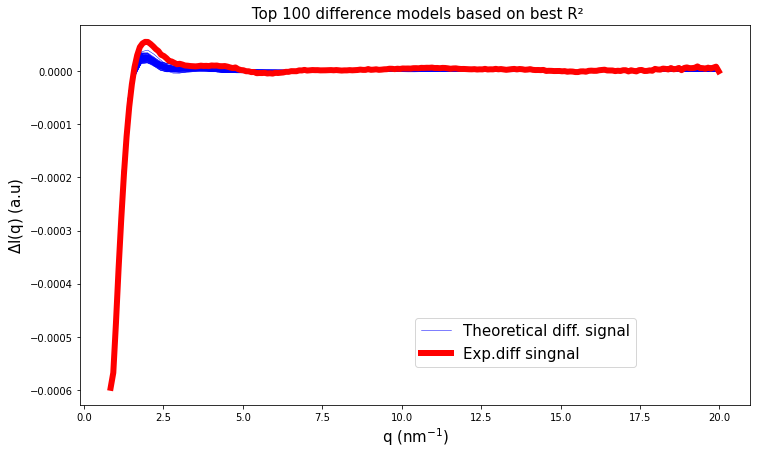

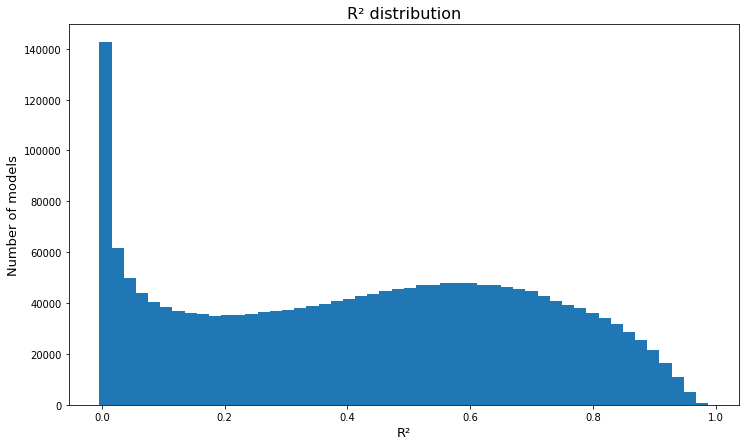

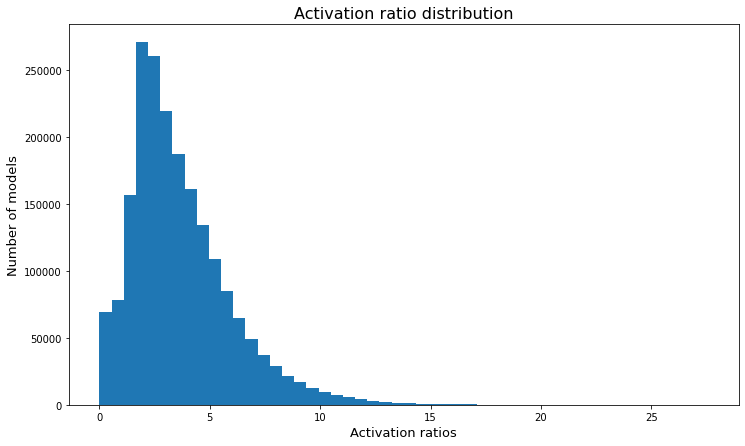

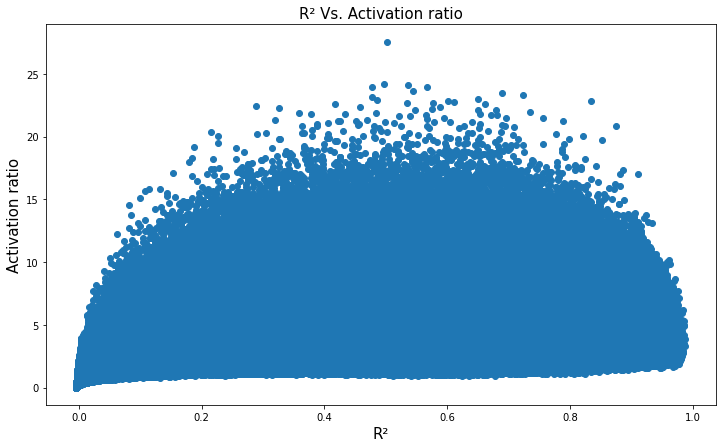

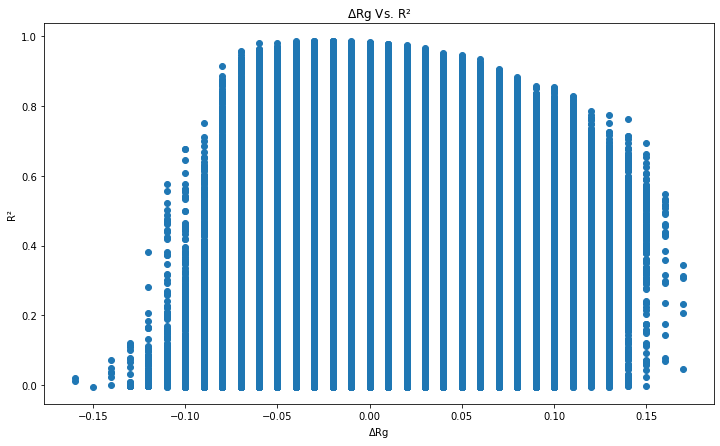

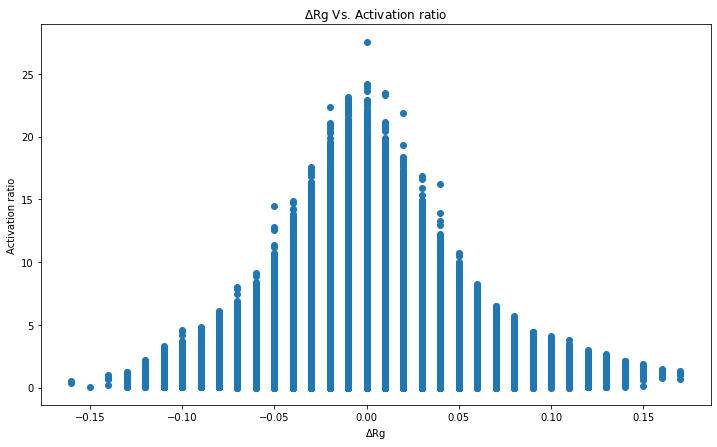

In [14]:
start_n = 0
q_max = 20
q_min = np.nanmin(XFEL_data[0].q[10])
make_plots(100, q_max, q_min)


# Show scaling - For test plotting scaled curves

## Main func.

In [172]:
def plot_scaled(n,light, dark, data, r2, activation_factor, abs_scale, diff_scale):
    # Plots an example curves to see if the scaling is working
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(24, 7))
    random_indices = np.random.choice(2000, n)
    for i in random_indices: 
        print(r2[i])
        scale_abs = abs_scale[i]
        scale_diff = diff_scale[i]
        light_index = light[i]
        dark_index = dark[i]
        dark_model = data[dark_index]
        light_model = data[light_index]
        
        diff = calc_diff(light_model, dark_model)
        diff = diff.scale_q(10)
        diff = diff.cut_q(XFEL_dark.q[0],np.max(diff.q))
        
        dark_model = dark_model.scale_q(10)
        dark_model = dark_model.cut_q(XFEL_dark.q[0],np.max(diff.q))
        
        ax1.plot(XFEL_dark_theo.q, XFEL_dark_theo.i*1e5/scale_abs, linewidth=3.0, color='Red', label='Experimental scaled to Theoretical')
        ax2.plot(XFEL_data[0].q, XFEL_data[0].i*1e5/scale_diff, linewidth=3.0, color='Red', label='Experimental scaled to Theoretical')
        
        if i == random_indices[-1]:
            ax1.plot(dark_model.q, dark_model.i, linewidth=3.0, color='Blue', label='Theoretical')
            ax2.plot(diff.q, diff.i, linewidth=3.0, color='Blue', label='Theoretical')
        else:
            ax1.plot(dark_model.q, dark_model.i, linewidth=3.0, color='Blue', )
            ax2.plot(diff.q, diff.i, linewidth=3.0, color='Blue')
  
   
             
    ax1.legend(loc=(0.4,0.5), frameon = True,fontsize=10)
    #ax1.set_yscale('log')
    ax1.set_xlim([0,10])
    ax1.set_title(' Exp. abs. signal scaled to Theoretical abs. signal', fontsize=15)
    ax1.set_ylabel('I$_{abs}$(s) [cm$^{-1}$]/c[mg/ml]',fontsize=15)
    ax1.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    #plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Scale_abs.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    ax2.legend(loc=(0.75,0.05), frameon = True,fontsize=10)
    #ax2.set_xlim([0.8,20])
    ax2.set_title(f' Exp. diff signal scaled to Theoretical diff. signal', fontsize=15)
    ax2.set_ylabel('I$_{abs}$(s) [cm$^{-1}$]/c[mg/ml]',fontsize=15)
    ax2.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Scaled_Example.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
  

    
    
   

    

## Plot

0.5250887654855472


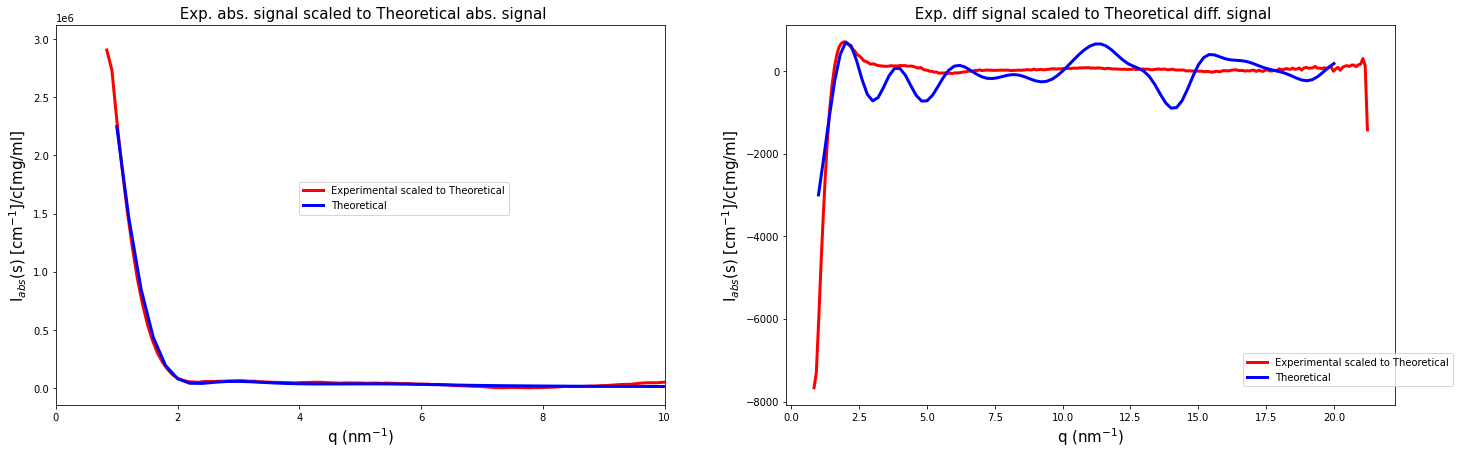

In [173]:
r2 = np.load(f'{data_dir}/R2.npy')
light_index = np.load(f'{data_dir}/light_index.npy')
dark_index = np.load(f'{data_dir}/dark_index.npy')
activation_factor = np.load(f'{data_dir}/occupancy.npy')
abs_scale = np.load(f'{data_dir}/abs_scales.npy')
diff_scale = abs(np.load(f'{data_dir}/diff_scales.npy'))



plot_scaled(1,light_index, dark_index, AF2_data, r2, activation_factor, abs_scale, diff_scale)

# Estimate activation factor FEB 23

## Load SAXS Data FEB 23 - Measurement 1


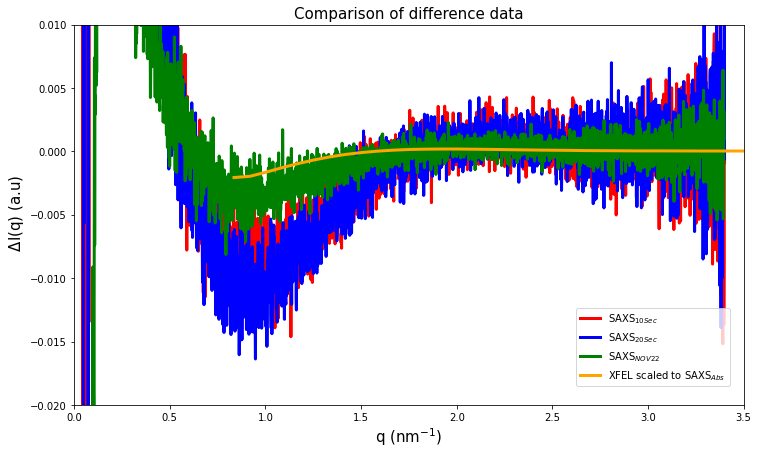

In [836]:
# Average runs
a = lights[0]
light_10sec = (lights[0] + lights[1]) /2
dark_10sec = (darks[0] + darks[1]) /2

light_20sec = (lights[2] + lights[3]) /2
dark_20sec = (darks[2] + darks[3]) /2

diff_10sec =light_10sec - dark_10sec
diff_20sec = light_20sec - dark_20sec

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.set_ylim([-.02,.01])
ax.set_xlim([0,3.5])
ax.set_ylabel(f' $\Delta$I(q) (a.u)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_title('Comparison of difference data',fontsize=15)
ax.plot(q_light, diff_10sec, linewidth=3.0, color='Red', label='SAXS$_{10 Sec}$')
ax.plot(q_light, diff_20sec, linewidth=3.0, color='Blue', label='SAXS$_{20 Sec}$')
ax.plot(df_temp20['q'].to_numpy()*10, diff_saxs1, linewidth=3.0, color='Green', label='SAXS$_{NOV22}$')
ax.plot(hamburg_q,h1/abs_scale,linewidth=3.0, label='XFEL scaled to SAXS$_{Abs}$', color='Orange')
ax.legend(loc=(0.75,0.05), frameon = True,fontsize=10)
plt.savefig(f'/home/leonardo/Solution_Scattering_2208/plots/Comparison_of_difference_data.png',bbox_inches='tight',facecolor=(1, 1, 1))

# Average errors
E_light_10sec = (E_light[0] + E_light[1]) /2
E_dark_10sec = (E_dark[0] + E_dark[1]) /2

E_light_20sec = (E_light[2] + E_light[3]) /2
E_dark_20sec = (E_dark[2] + E_dark[3]) /2


## Dark 

### Prep data

In [851]:
dark_exp = np.sum(avg_S_off[150:175,:],axis = 0)/25
dark_exp = dark_exp - buffer_off*0.935
q_range = [1.1,1.2]

q_dark_indices = np.logical_and(q_dark>q_range[0], q_range[1]>q_dark)
exfel_indices = np.logical_and(hamburg_q>q_range[0], q_range[1]>hamburg_q)


q_dark_cut = q_dark[q_dark_indices]
exfel_q =hamburg_q[exfel_indices]

dark_10sec_cut = dark_10sec[q_dark_indices]
E_dark_10sec_cut = E_dark_10sec[q_dark_indices]
dark_exp_cut = dark_exp[exfel_indices]


exp_interpolated_dark = interpolate_curve(q_dark_cut,exfel_q,dark_exp_cut)
dark_scale = chi_sq(dark_10sec_cut,exp_interpolated_dark[0],E_dark_10sec_cut)[0]
print(dark_scale)*
1/dark_scale[0]

Optimization terminated successfully.
         Current function value: 91.590007
         Iterations: 21
         Function evaluations: 42
[4.01544189]


0.24903859307787016

### Plot

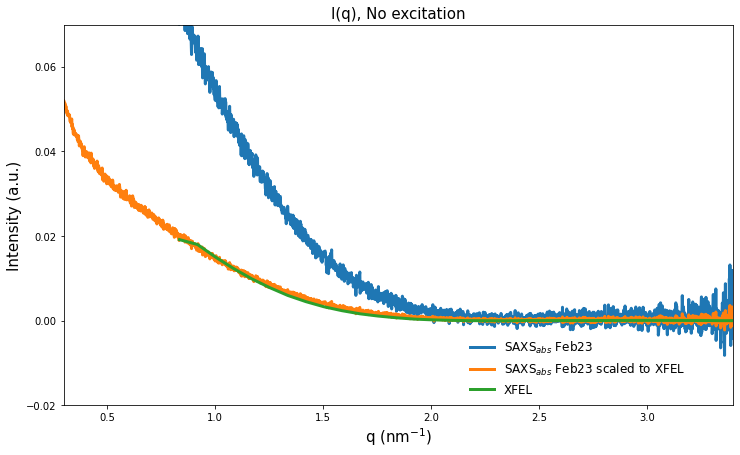

In [854]:
#Plot the dark data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
#ax.plot(q_dark, exp_interpolated_dark,linewidth=3.0, label='XFEL_interpolated') 
ax.plot(q_dark, dark_10sec,linewidth=3.0, label='SAXS$_{abs}$ Feb23')
ax.plot(q_dark, dark_10sec*1/3.7,linewidth=3.0, label='SAXS$_{abs}$ Feb23 scaled to XFEL')
ax.plot(hamburg_q, dark_exp,linewidth=3.0, label='XFEL')


ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q), No excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
#ax.set_yscale('log')
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/Solution_Scattering_2208/plots/Dark_scaled_SAXS_FEB23',bbox_inches='tight',facecolor=(1, 1, 1))

## Diff

### Prep data

In [623]:
diff_exp = h1
q_range = [0.8,1]

q_dark_indices = np.logical_and(q_dark>q_range[0], q_range[1]>q_dark)
exfel_indices = np.logical_and(hamburg_q>q_range[0], q_range[1]>hamburg_q)


q_dark_cut = q_dark[q_dark_indices]
exfel_q =hamburg_q[exfel_indices]

diff_10sec_cut = diff_20sec[q_dark_indices]
E_diff_10sec = E_dark_10sec[q_dark_indices]
diff_exp_cut = diff_exp[exfel_indices]


exp_interpolated_diff = interpolate_curve(q_dark_cut,exfel_q,diff_exp_cut)
diff_scale = chi_sq(diff_10sec_cut,exp_interpolated_diff[0],E_diff_10sec)[0]
print(diff_scale)
1/diff_scale[0]

Optimization terminated successfully.
         Current function value: 99.226501
         Iterations: 17
         Function evaluations: 34
[17.75415039]


0.05632485801900414

### Plot

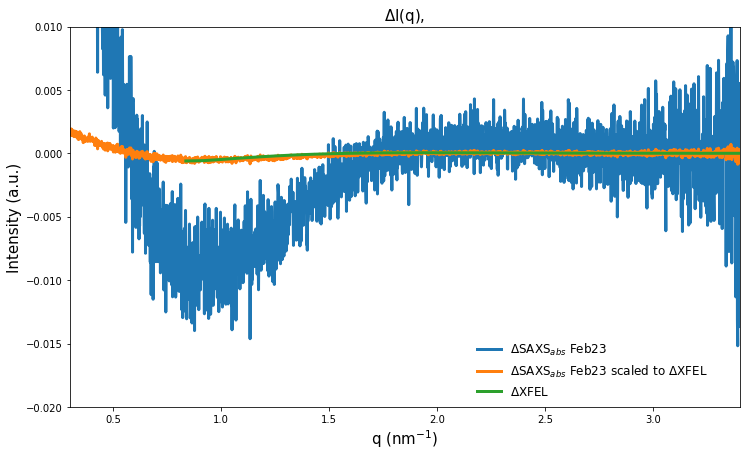

In [859]:
#Plot the dark data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
#ax.plot(q_dark, exp_interpolated_dark,linewidth=3.0, label='XFEL_interpolated') 
ax.plot(q_dark, diff_10sec,linewidth=3.0, label=r'$\Delta$SAXS$_{abs}$ Feb23')
ax.plot(q_dark, diff_10sec*1/diff_scale[0],linewidth=3.0, label='$\Delta$SAXS$_{abs}$ Feb23 scaled to $\Delta$XFEL')
ax.plot(hamburg_q, diff_exp,linewidth=3.0, label='$\Delta$XFEL')


ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'$\Delta$I(q), ',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.01])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/Solution_Scattering_2208/plots/Diff_scaled_SAXS_FEB23',bbox_inches='tight',facecolor=(1, 1, 1))

### Calc activation factor

In [628]:
# Based on scaling XFEL to exp. 
#
#
activation_factor = (diff_scale/dark_scale)
print(1/diff_scale)
print(dark_scale)
print(activation_factor[0])
print(1/activation_factor[0])

[0.05632486]
[3.45599365]
5.137205729120676
0.19465835178284127


## Load SAXS Data FEB 23 - Measurement 2

### Plot Illumination series 

## Plot comparison of diff data, abs data and excited data. 

array([-1, -3, -6, -2,  3,  9])

[ 0.125075    0.290498   -0.110083   ... -0.00132098 -0.00984314
  0.00409746]
[0.045      0.04630494 0.04760988 ... 3.3973901  3.3986951  3.4       ]


(0.0, 3.0)

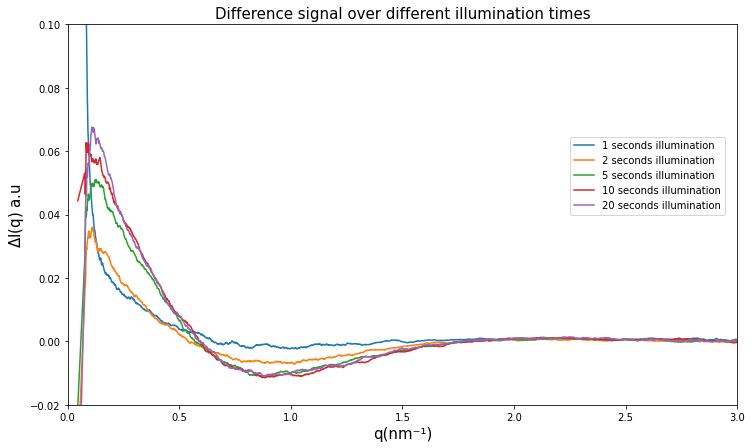

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.set_title('Difference signal over different illumination times', fontsize=15)
ax.set_xlabel(r'q(nm⁻¹)',fontsize=15)
ax.set_ylabel(f'$\Delta$I(q) a.u', fontsize=15)
    
for data, time in zip(SAXS_diff_illumination, time_illumination):
    data = data.scale_q(10)
    data = data.remove_nan()
    data_smooth = savgol_filter(data.i, window_length=50, polyorder=1)
    ax.plot(data.q, data_smooth, label=f'{time} seconds illumination')
    #ax.plot(data.q,data.i, label=f'{time} seconds illumination')
    


twenty = SAXS_diff_steady[1].scale_q(10)
twenty_smooth = savgol_filter(twenty.i, window_length=50, polyorder=1)
ax.plot(twenty.q, twenty_smooth, label=f'20 seconds illumination')    

print(data.i)
print(data.q)
ax.legend(loc=(0.75,0.5), frameon = True,fontsize=10)
ax.set_ylim([-.02,.1])
ax.set_xlim([0,3])

    


## Visualisation of activation factor


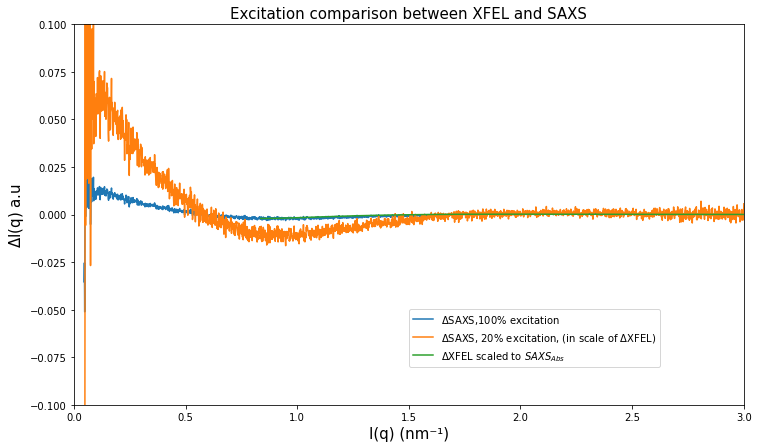

In [835]:
# Interpolate SAXS on XFEL data
differences = np.array([diffs[0], diffs[2], diff_10sec, diff_20sec])
time_points = {0:'1s', 1:'5s', 2:'10s', 3:'20s' }
interpolated_diffs = []
abs_scale = 1/dark_scale

for diff in differences: 
    interpolated_diff = interpolate_curve(hamburg_q,q_light,diff)
    interpolated_diffs.append(interpolated_diff)
    
fig, ax3 = plt.subplots(1, 1, figsize=(12, 7))
for i in enumerate(interpolated_diffs):
    diff = i[1]
    i = i[0]
    #ax3.plot(hamburg_q,diff, label = f'Illumination time: {time_points[i]}')
    ax3.set_xlim([0,3])
    ax3.set_ylim([-0.1,.1])

ax3.plot(q_light,differences[-1]/activation_factor, label = f'$\Delta$SAXS,100% excitation ')
ax3.plot(q_light,differences[-1], label = f'$\Delta$SAXS, 20% excitation, (in scale of $\Delta$XFEL)')
ax3.plot(hamburg_q,diff_exp/abs_scale, label = '$\Delta$XFEL scaled to $SAXS_{Abs}$')
ax3.set_title('Excitation comparison between XFEL and SAXS', fontsize=15)
ax3.set_ylabel(r'$\Delta$I(q) a.u', fontsize=15)
ax3.set_xlabel(r'I(q) (nm⁻¹)', fontsize=15)
#ax3.hlines(0.014, xmin = 0.13, xmax = 0.15, color='black', linestyle='-')
#ax3.hlines(0.07, xmin = 0.13, xmax = 0.15, color='black', linestyle='-')
ax3.legend(loc=(0.5,0.1), frameon = True,fontsize=10)
#ax3.vlines(0.14, ymin = 0.07, ymax = 0.014, color='black', linestyle='-')
#plt.text(0.2,.07,'Activation factor of 0.2')
plt.savefig(f'/home/leonardo/Solution_Scattering_2208/plots/Comparison_of_activation_factor_2.png',bbox_inches='tight',facecolor=(1, 1, 1))



# Test with Unfolded Helix from Collabfold


## Load curve bsaed on data from collab prediction

In [1060]:
path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/NO_helix/no_helix.txt'
nohelix = np.loadtxt(path,usecols=[1,2], delimiter=',',skiprows=1).T

# no helixq = nohelix[0]
q = nohelix[0]
I =nohelix[1]

# Dark
path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/NO_helix/ref/dark.txt'
dark = np.loadtxt(path,usecols=[1,2], delimiter=',',skiprows=1).T
q = dark[0] *10 
I_dark = dark[1]
# Get a dark structure and take nohelix - ref 
theory_diff = (I - I_dark)

            

[5.85253906e-05]
0.8724509337570171
0.09778303522261449
0.9724046682121505


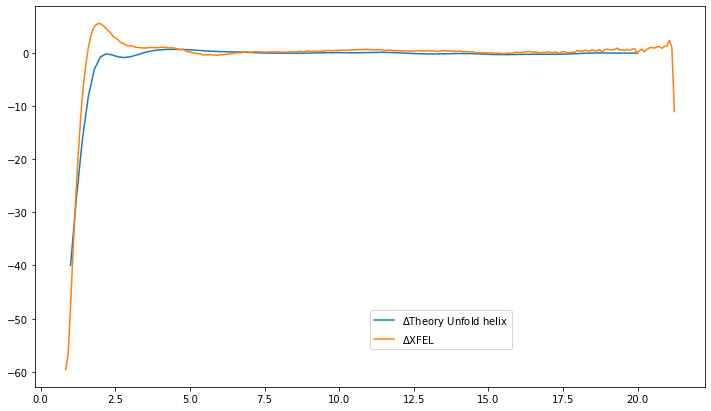

In [1070]:
# Def plot
fig, ax3 = plt.subplots(1, 1, figsize=(12, 7))
theory_diff = I - I_dark

h1_af2 = h1[10:255]
h1_q = hamburg_q[10:255]
q_max,q_min = (h1_q[-1],h1_q[0])
#Decide what q-range
theory_q,crysol_i = cut_q(q,q_max,q_min)
theory_diff = theory_diff[crysol_i]


xfel_q,xfel_i = cut_q(h1_q,q_max,q_min)
xfel_cut = h1_af2[xfel_i]
#interpolate exp diff data
exp_interpolated = interpolate_curve(theory_q,xfel_q,xfel_cut)
exp_scaled_occupancy = exp_interpolated * 1e5
exp_scaled = exp_interpolated*1/theory_q
    
#interpolat exp abs data
dark_abs = np.sum(avg_S_off[150:175,:],axis = 0)/25
dark_abs = (dark_abs - buffer_off*0.905)[10:255]
interpolated_abs = interpolate_curve(theory_q,xfel_q,dark_abs[xfel_i])
# scale theory
theory_scaled = theory_diff * 1/theory_q
# Scale exp. diff and exp. abs to theory (factor of 1*e5 for faster calc.)
scale_diff,fopt_diff = SSE(exp_interpolated * 1e5,theory_diff, 0.0002)
if scale_diff > 0:
    scale_abs,fopt_abs = SSE(interpolated_abs * 1e5, I_dark[crysol_i], 0.0002)
else:
    scale_abs,fopt_abs = SSE(interpolated_abs * 1e5, I[crysol_i], 0.0002)
            
         

            
# Calculate the R2 between intepolated experimental curve and the theoretical curve
r2= calc_r2(exp_interpolated, theory_diff*scale_diff/1e5)
# Calc Pearson CC
corr = np.corrcoef(exp_scaled,theory_scaled, rowvar=True)[0][1]            
# Calc occupance
occupancy = (scale_diff/scale_abs)[0]
            

print(scale_diff)
print(r2)
print(occupancy)
print(corr)


# compare to acutal diff signal both SAXS and XFEL 
#ax3.plot(q_light,differences[-1], label = f'$\Delta$SAXS, 20% excitation, (in scale of $\Delta$XFEL)')
ax3.plot(theory_q,theory_diff*scale_diff, label = f'$\Delta$Theory Unfold helix')
ax3.plot(diff_q,diff_exp * 1e5, label = '$\Delta$XFEL')
ax3.legend(loc=(0.5,0.1), frameon = True,fontsize=10)


## Difference data

In [1467]:
#q range in nm⁻¹
q_range = [hamburg_q[0],diamond_q[-1]*10]

#q_range = [hamburg_q[0],2]

h_indices = hamburg_q<=q_range[1]
hamburg_q_cut = hamburg_q[h_indices]
h1_cut = h1[hamburg_q<=q_range[1]]
diamond_q_cut = diamond_q[np.logical_and(diamond_q >= q_range[0]/10, diamond_q<=q_range[1]/10)]
diff_cut =diff[np.logical_and(diamond_q >= q_range[0]/10, diamond_q<=q_range[1]/10)]
E_diff_cut = E_diff[np.logical_and(diamond_q >= q_range[0]/10, diamond_q<=q_range[1]/10)]
interpolated_h = interpolate_curve(diamond_q_cut*10,hamburg_q_cut,h1_cut)

solution = sse(diff_cut, interpolated_h[0], E_diff_cut)

print(solution[0][0])
1/solution[0][0]
#print(diff.shape)

Optimization terminated successfully.
         Current function value: 1101.788514
         Iterations: 13
         Function evaluations: 26
7.028369140624999


0.14228051771211817

In [1468]:
print('Chi-square minimization for diff data with k=1/10.69 optmized for full q-range:',np.nansum(((interpolated_h[0]-((1/11.07)*diff_cut))/E_diff_cut)**2))
print('Chi-square minimization for diff data with k=1/10.69 optmized for full qmax=3:',np.nansum(((interpolated_h[0]-((1/10.69)*diff_cut))/E_diff_cut)**2))
print('Chi-square minimization for diff data with k=1/10.69 optmized for full qmax2.5:',np.nansum(((interpolated_h[0]-((1/10.23)*diff_cut))/E_diff_cut)**2))
print('Chi-square minimization for diff data with k=1/10.69 optmized for full qmax=2:',np.nansum(((interpolated_h[0]-((1/9.817)*diff_cut))/E_diff_cut)**2))

#print('Least square for diff data with k=1/10.24 optimized with qmax = 2.5 nm⁻¹',np.nansum(())**2)))
#print('Least square for diff data with k=1/9.826 optimized with qmax = 2.0 nm⁻¹',np.nansum((interpolated_h[0]-(1/cut_25)*diff_cut)/(np.std(interpolated_h[0])*E20_cut))**2)
#print('Least square for diff data with k=1/10.24 optimized with qmax = 2.5 nm⁻¹',np.nansum(())**2))
#print('Least square for diff data with k=1/10.71 optimized with qmax = 3.0 nm⁻¹',np.nansum((interpolated_h_dark[0]-(1/cut_3*diff))**2))
#print('Least square for diff data with k=1/11.08 optimized with full q-range (qmax ~3.4 nm⁻¹)',np.nansum((interpolated_h_dark[0]-(1/12*diff))**2))

Chi-square minimization for diff data with k=1/10.69 optmized for full q-range: 14.163375418287108
Chi-square minimization for diff data with k=1/10.69 optmized for full qmax=3: 14.194219176238928
Chi-square minimization for diff data with k=1/10.69 optmized for full qmax2.5: 14.32880471685864
Chi-square minimization for diff data with k=1/10.69 optmized for full qmax=2: 14.563652025335784


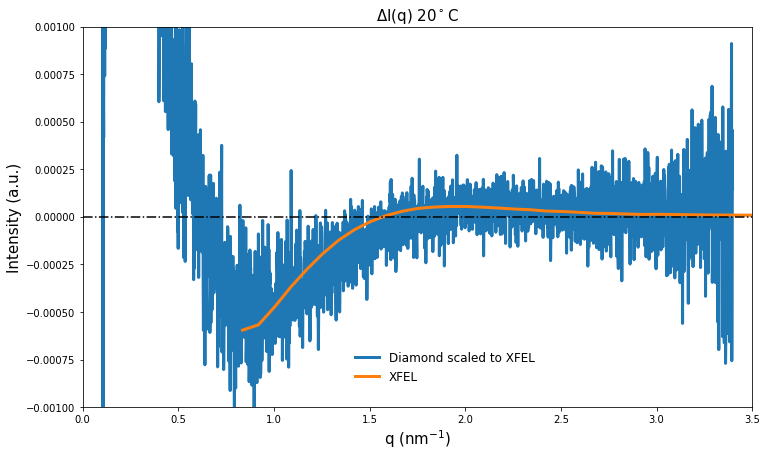

In [1483]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(diamond_q*10,diff*(1/solution[0][0]),linewidth=3.0, label='Diamond scaled to XFEL')
#ax.plot(diamond_q*10,diff*(1/10.23),linewidth=3.0, label='Diamond scaled to XFEL qmax=2.5nm$^{-1}$')
#ax.plot(diamond_q*10,diff*(1/10.69),linewidth=3.0, label='Diamond scaled to XFEL qmax=3.0nm$^{-1}$')
#ax.plot(diamond_q*10,diff_cut*(1/solution[0][0]),linewidth=3.0, label='Diamond scaled to XFEL full q-range')
ax.plot(hamburg_q,h1,linewidth=3.0, label='XFEL')
ax.set_title(r'$\Delta$I(q) 20$^\circ$C',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_ylim([-.001,.001])
ax.set_xlim([0,3.5])
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.legend(loc=(0.4,0.05), frameon = False,fontsize=12)
ax.hlines(0, xmin = q[0], xmax = hamburg_q[-1], color='k', linestyle='-.')
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/Diff_curve_comparison_310123',bbox_inches='tight',facecolor=(1, 1, 1))

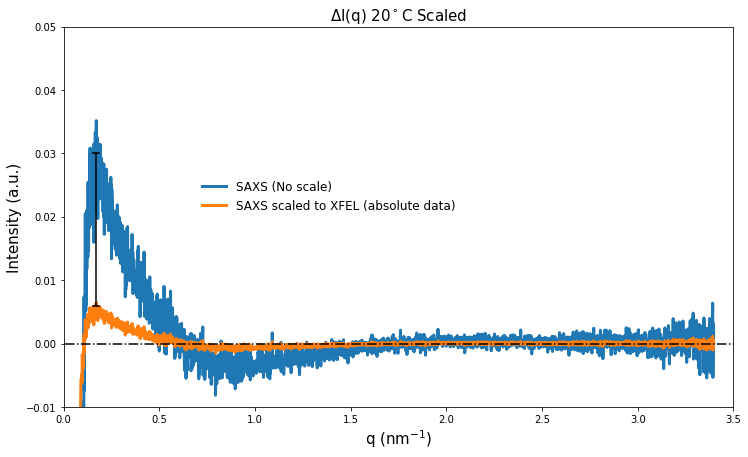

In [1669]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

#SAXS
ax.set_ylim([-.01,.05])
ax.plot(diamond_q*10,diff_cut,linewidth=3.0, label='SAXS (No scale)')
ax.plot(diamond_q*10,diff_cut*(1/(5.42)),linewidth=3.0, label='SAXS scaled to XFEL (absolute data)')
#ax.plot(diamond_q*10,diff_cut*(1/(5.42)*5.42*1.28),linewidth=3.0, label='SAXS scaled to XFEL (absolute data)')
#ax.plot(hamburg_q,h1*(9.817),linewidth=3.0, label='XFEL scaled to Diamond qmax=2nm$^{-1}$')
#ax.plot(hamburg_q,h1*(10.23),linewidth=3.0, label='XFEL scaled to Diamond qmax=2.5nm$^{-1}$')
#ax.plot(hamburg_q,h1*(10.69),linewidth=3.0, label='XFEL scaled to Diamond qmax=3.0nm$^{-1}$')


#XFEL
#ax.set_ylim([-.00004,.0006])
#ax.plot(hamburg_q,h1,linewidth=3.0, label='XFEL no scale')
#ax.plot(hamburg_q,h1*5.42,linewidth=3.0, label='XFEL scaled to Diamond ')

ax.set_title(r'$\Delta$I(q) 20$^\circ$C Scaled',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)

ax.hlines(0.03, xmin = 0.15, xmax = 0.19, color='black', linestyle='-')
ax.hlines(0.006, xmin = 0.15, xmax = 0.19, color='black', linestyle='-')

ax.vlines(0.17, ymin = 0.0058, ymax = 0.03, color='black', linestyle='-')


ax.set_xlim([0,3.5])
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.legend(loc=(0.2,0.5), frameon = False,fontsize=12)
ax.hlines(0, xmin = q[0], xmax = hamburg_q[-1], color='k', linestyle='-.')
#plt.savefig(f'/home/leonardo/SAXS_222711/Plots/Diff_curve_scaled_ratio',bbox_inches='tight',facecolor=(1, 1, 1))

In [1655]:
no_scale = .03
scale = np.nanmax(diff_cut/5.42)

1/0.78
ratio=(no_scale-scale)/no_scale

print(1/ratio)
print(5.42/ratio)



1.2760247043405246
6.916053897525643


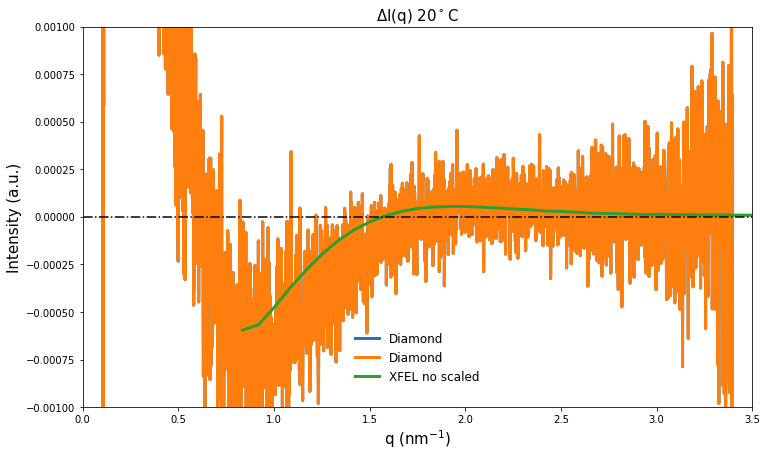

In [1553]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

diff_htest = light_h-dark_h


ax.plot(diamond_q*10,diff_cut*(1/5),linewidth=3.0, label='Diamond')

ax.plot(diamond_q*10,diff_cut*(1/5),linewidth=3.0, label='Diamond')

ax.plot(hamburg_q,h1,linewidth=3.0, label='XFEL no scaled')



ax.set_title(r'$\Delta$I(q) 20$^\circ$C',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_ylim([-.001,.001])
ax.set_xlim([0,3.5])
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.legend(loc=(0.4,0.05), frameon = False,fontsize=12)
ax.hlines(0, xmin = q[0], xmax = hamburg_q[-1], color='k', linestyle='-.')
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/Diff_curve_comparison_reverse_310123',bbox_inches='tight',facecolor=(1, 1, 1))




## Absolute data

### Dark

In [295]:
dark_h = np.sum(avg_S_off[150:175,:],axis = 0)/25
dark_h = (dark_h - buffer_off*0.935)[10:255]
interpolated_h_dark = interpolate_curve(diamond_q*10,hamburg_q[10:255],dark_h)
solution_dark = SSE(dark_I1,interpolated_h_dark[0])
print(solution_dark[0][0])
1/solution_dark[0][0]

4.266015625000014


0.23441076824466547

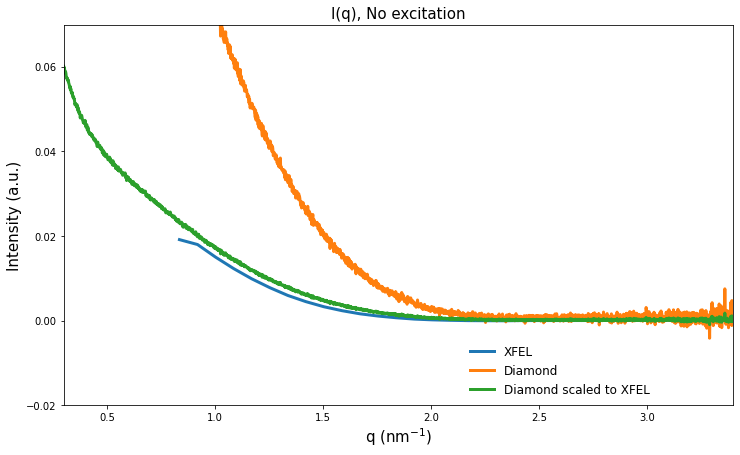

In [296]:
#Plot the dark data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(hamburg_q[10:255], dark_h,linewidth=3.0, label='XFEL')
ax.plot(diamond_q*10, dark_I1,linewidth=3.0, label='Diamond')

ax.plot(diamond_q*10, dark_I1*1/solution_dark[0][0],linewidth=3.0, label='Diamond scaled to XFEL')


ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q), No excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/No_excitation_310123',bbox_inches='tight',facecolor=(1, 1, 1))

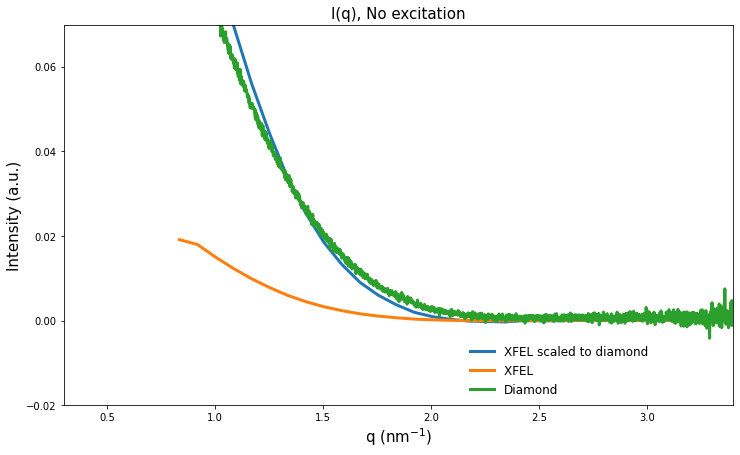

In [2176]:
#Plot the dark data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(hamburg_q,(dark_h)*(5.67),linewidth=3.0, label='XFEL scaled to diamond')
ax.plot(hamburg_q,(dark_h),linewidth=3.0, label='XFEL ')
ax.plot(diamond_q*10, dark_I1,linewidth=3.0, label='Diamond')




ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q), No excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/No_excitation_reverse_310123_old',bbox_inches='tight',facecolor=(1, 1, 1))

In [2164]:
from fractions import Fraction
activation_factor=solution_dark[0][0]/solution[0][0]
print(activation_factor)
print(1/activation_factor)


NameError: name 'solution' is not defined

### Light

In [2177]:
light_h=np.sum(avg_S_on[150:175,:],axis = 0)/25
light_h = light_h - buffer_on*0.935
interpolated_h_light = interpolate_curve(diamond_q*10,hamburg_q,light_h)
solution_light = sse(light_I1,interpolated_h_light[0], E_light)
print(solution_light[0][0])
print(1/solution_light[0][0])

Optimization terminated successfully.
         Current function value: 5165.846266
         Iterations: 18
         Function evaluations: 36
5.025524902343747
0.19898418959850966


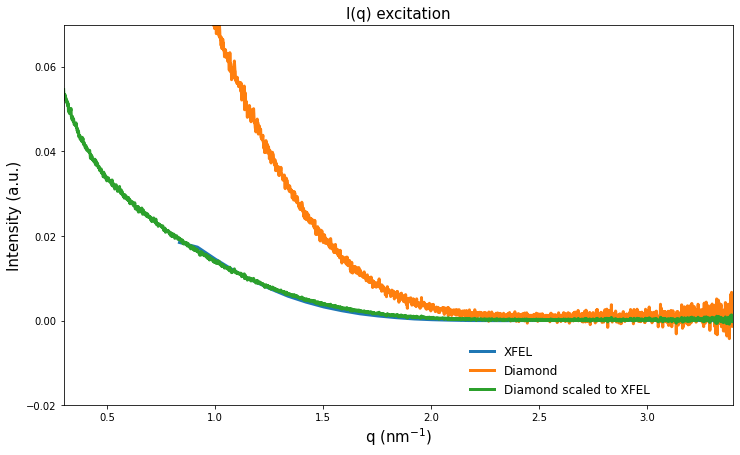

In [2178]:
#Plot the light data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(hamburg_q, light_h,linewidth=3.0, label='XFEL')
ax.plot(diamond_q*10, light_I1,linewidth=3.0, label='Diamond')
ax.plot(diamond_q*10, light_I1*1/solution_light[0][0],linewidth=3.0, label='Diamond scaled to XFEL')


ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q) excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/excitation',bbox_inches='tight',facecolor=(1, 1, 1))

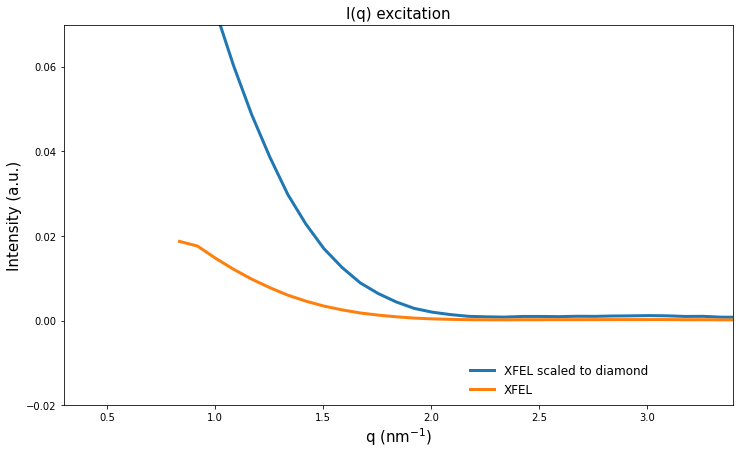

In [2153]:
#Plot the light data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(hamburg_q,(light_h)*solution_dark[0][0],linewidth=3.0, label='XFEL scaled to diamond')
ax.plot(hamburg_q,(light_h),linewidth=3.0, label='XFEL')
#ax.plot(diamond_q*10, light_I1,linewidth=3.0, label='Diamond')




ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q) excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/No_excitation',bbox_inches='tight',facecolor=(1, 1, 1))

### Light and Dark


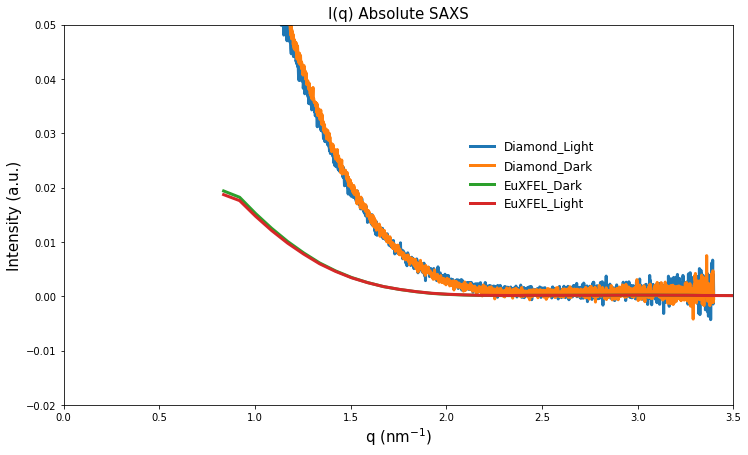

In [2152]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
#solution = sse(light_I1, dark_I1, E_diff)
#print(solution[0][0])

ax.plot(diamond_q*10, light_I1,linewidth=3.0, label='Diamond_Light')
ax.plot(diamond_q*10, dark_I1,linewidth=3.0, label='Diamond_Dark')


ax.plot(hamburg_q, dark_h,linewidth=3.0, label='EuXFEL_Dark')
ax.plot(hamburg_q, light_h,linewidth=3.0, label='EuXFEL_Light')

#ax.plot(diamond_q, dark_I1,linewidth=3.0, label='Diamond_Dark_scaled')
ax.legend(loc=(0.6,0.5), frameon = False,fontsize=12)
ax.set_title(r'I(q) Absolute SAXS',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)#ax.set_ylim([-.02,.02])
ax.set_xlim([0,3.5])
ax.set_ylim([-.02,.05])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/Light_Dark_comparison',bbox_inches='tight',facecolor=(1, 1, 1))